## Steup

### imports and globals

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import scipy.stats as stats
import tqdm
import concurrent.futures
import threading

In [2]:
dim = 20

In [3]:
seeds = range(1000,1100)

### stepsize classes

In [4]:
class Params:
    def __init__(self, L0=None, L1=None, sigma=None, R0=None, T=None, delta=None, num_grads_per_step=1, name="[param]", plot_color="tab:blue"):
        self.L0 = L0
        self.L1 = L1
        self.sigma = sigma
        self.R0 = R0
        self.T = T
        self.delta = delta
        self.num_grads_per_step = num_grads_per_step
        self.name = name
        self.plot_color = plot_color

    def prepare_for_run(self):
        pass

    def eta(self, g, dbl_g):
        raise NotImplementedError

    def alpha(self, g, dbl_g):
        raise NotImplementedError

    def is_clipped(self, g, dbl_g):
        raise NotImplementedError

    def stepsize(self, g, dbl_g):
        return self.eta(g, dbl_g) * self.alpha(g, dbl_g)

    def __call__(self, g, dbl_g):
        return self.stepsize(g, dbl_g)

In [5]:
class DefaultNoClipping(Params):
    def __init__(self, L0, L1, sigma, R0, T, delta, name="[param]", const=1):
        super().__init__(L0, L1, sigma, R0, T, delta, 1, name, plot_color="tab:blue")
        self.const = const

    def eta(self, g, dbl_g):
        return self.const * min(1/(11*self.L0), 1/(self.L0 + (self.T ** 0.5) * self.sigma / self.R0))

    def alpha(self, g, dbl_g):
        return 1

    def is_clipped(self, g, dbl_g):
        return False

In [6]:
class StandardClippingDouble(Params):
    def __init__(self, L0, L1, sigma, R0, T, delta, name="[param]", const=1, const_c=None):
        super().__init__(L0, L1, sigma, R0, T, delta, 2, name, plot_color="tab:blue")
        if const_c == None:
            self.c = (1/L1) * max(10*L0, (T ** 0.5) * sigma / R0)
        else:
            self.c = const_c
        self.const = const

    def eta(self, g, dbl_g):
        return self.const * min(1/(11*self.L0), 1/(self.L0 + (self.T ** 0.5) * self.sigma / self.R0))

    def alpha(self, g, dbl_g):
        if norm(dbl_g) == 0:
            return 1
        return min(1, self.c / norm(dbl_g))

    def is_clipped(self, g, dbl_g):
        return (norm(dbl_g) > self.c)

In [7]:
class StandardClippingSingle(Params):
    def __init__(self, L0, L1, sigma, R0, T, delta, name="[param]", const=1):
        super().__init__(L0, L1, sigma, R0, T, delta, 1, name, plot_color="tab:purple")
        self.c = (1/L1) * max(10*L0, (T ** 0.5) * sigma / R0)
        self.const = const

    def eta(self, g, dbl_g):
        return self.const * min(1/(11*self.L0), 1/(self.L0 + (self.T**0.5) * self.sigma/self.R0))

    def alpha(self, g, dbl_g):
        if norm(g) == 0:
            return 1
        return min(1, self.c / norm(g))

    def is_clipped(self, g, dbl_g):
        return (norm(g) > self.c)

In [8]:
class ImplicitClipping(Params):
    def __init__(self, L0, L1, sigma, R0, T, delta, name="[param]", const=1):
        super().__init__(L0, L1, sigma, R0, T, delta, 2, name, plot_color="tab:orange")
        self.c = (1/L1) * max(10*L0, (T ** 0.5) * sigma / R0)
        self.const = const

    def eta(self, g, dbl_g):
        return self.const * 1 / (self.L0 + norm(dbl_g)*self.L1 + (self.T**0.5) * self.sigma / self.R0)

    def alpha(self, g, dbl_g):
        return 1

    def is_clipped(self, g, dbl_g):
        return (norm(dbl_g) > self.c)

In [9]:
class Adaptive(Params):
    def __init__(self, L0, L1, sigma, R0, T, delta, name="[param]", const=1):
        super().__init__(L0, L1, sigma, R0, T, delta, 1, name, plot_color="tab:green")
        self.c = None
        self.G = 10**(-3)
        self.const = const

    def prepare_for_run(self):
        self.G = 10**(-3)

    def eta(self, g, dbl_g):
        self.G += norm(g)**2
        return self.const * self.R0 / (self.G ** 0.5)

    def alpha(self, g, dbl_g):
        return 1

    def is_clipped(self, g, dbl_g):
        return False

In [10]:
class AdaptiveClipped(Params):
    def __init__(self, L0, L1, sigma, R0, T, delta, name="[param]", const=1):
        super().__init__(L0, L1, sigma, R0, T, delta, 2, name, plot_color="tab:green")
        self.c = (1/L1) * max(10*L0, (T ** 0.5) * sigma / R0)
        self.G = 10**(-3)
        self.const = const

    def prepare_for_run(self):
        self.G = 10**(-3)

    def eta(self, g, dbl_g):
        self.G += self.alpha(g, dbl_g)**2 * norm(g)**2
        return self.const * self.R0 / (self.G ** 0.5)

    def alpha(self, g, dbl_g):
        if norm(dbl_g) == 0:
            return 1
        return min(1, self.c / norm(dbl_g))

    def is_clipped(self, g, dbl_g):
        return (norm(dbl_g) > self.c)

### (L0,L1) functions

In [11]:
class Function:
    def __init__(self, val_func, grad_func, argmin, L0, L1, name="[func]"):
        self.val = val_func
        self.grad = grad_func
        self.argmin = argmin
        self.L0 = L0
        self.L1 = L1
        self.name = name

    def __call__(self, x):
        return self.val(x)

In [12]:
A = np.diag(np.linspace(1/dim,1,dim))

functions = {
    "||x||^4": Function(
        val_func  = lambda x: np.power(norm(A @ x),4),
        grad_func = lambda x: 4 * np.power(norm(A @ x),2) * (A**2) @ x,
        argmin = np.array([0] * dim),
        L0 = 4,
        L1 = 3,
        name = "x^4"),

    # "e^||x|| + e^-||x||": Function(
    #     val_func  = lambda x: np.exp(norm(A @ x)) + np.exp(-norm(A @ x)),
    #     grad_func = lambda x: (np.exp(norm(A @ x)) - np.exp(-norm(A @ x))) * ((A @ x @ A) / norm(A @ x)),
    #     argmin = np.array([0] * dim),
    #     L0 = (np.exp(1) + 2*np.exp(-1)) * norm(A**2,ord=2),
    #     L1 = norm(A,ord=2),
    #     name = "e^||x|| + e^-||x||")
}

### optimization and plotting

In [13]:
def optimize(x_0, func: Function, params: Params, T, every, rand_state):
    x_t = np.array(x_0)

    all_samples = stats.norm.rvs(scale=params.sigma/(2*dim)**0.5, size=(2*T,np.size(x_0)), random_state=rand_state)
    g_samples = all_samples[:T]
    dbl_g_samples = all_samples[T:]

    iterates = []
    tau_2_iterates = []
    averages = []
    tau_2_averages = []
    grads = []

    params.prepare_for_run()

    for t in range(0,T,params.num_grads_per_step):
        g_t     = func.grad(x_t) + g_samples[t]
        dbl_g_t = func.grad(x_t) + dbl_g_samples[t]

        iterates.append(x_t)
        averages.append(np.mean(iterates, axis=0))
        if not params.is_clipped(g_t, dbl_g_t):
            tau_2_iterates.append(x_t)
        if len(tau_2_iterates) == 0:
            tau_2_averages.append(x_0)
        else:
            tau_2_averages.append(np.mean(tau_2_iterates, axis=0))
        grads.append(g_t)

        x_t = x_t - params(g_t, dbl_g_t) * g_t
        x_t = np.clip(x_t, -1e50, 1e50)

    lists = (
    np.array([func(x) - func(func.argmin) for x in iterates[::every]]),
    np.array([func(x) - func(func.argmin) for x in averages[::every]]),
    np.array([func(x) - func(func.argmin) for x in tau_2_averages[::every]]),
    np.array([norm(g) for g in grads[::every]])
    )

    return lists

In [14]:
def optimize_multi(x_0, func: Function, params: Params, T, every):
        rand_states = [np.random.default_rng(seed) for seed in seeds]

        results = np.array([optimize(x_0, func, params, T, every, state) for state in rand_states])

        regular_iterates_mean     = np.median([res[0] for res in results], axis=0)
        average_iterates_mean     = np.median([res[1] for res in results], axis=0)
        tau2average_iterates_mean = np.median([res[2] for res in results], axis=0)
        grad_norm_mean            = np.median([res[3] for res in results], axis=0)

        regular_iterates_bottom     = np.percentile([res[0] for res in results], 25, axis=0)
        average_iterates_bottom     = np.percentile([res[1] for res in results], 25, axis=0)
        tau2average_iterates_bottom = np.percentile([res[2] for res in results], 25, axis=0)
        grad_norm_bottom            = np.percentile([res[3] for res in results], 25, axis=0)

        regular_iterates_top     = np.percentile([res[0] for res in results], 75, axis=0)
        average_iterates_top     = np.percentile([res[1] for res in results], 75, axis=0)
        tau2average_iterates_top = np.percentile([res[2] for res in results], 75, axis=0)
        grad_norm_top            = np.percentile([res[3] for res in results], 75, axis=0)

        return ((regular_iterates_mean, regular_iterates_bottom, regular_iterates_top), \
               (average_iterates_mean, average_iterates_bottom, average_iterates_top), \
               (tau2average_iterates_mean, tau2average_iterates_bottom, tau2average_iterates_top), \
               (grad_norm_mean, grad_norm_bottom, grad_norm_top))

In [15]:
def grid_search(params, grid, has_threshold):
    results = []
    for lr in grid:
        params.const = lr
        result = optimize_multi(x_0, func, params, T, every)
        if has_threshold:
            results.append(result[2][0][-1])
        else:
            results.append(result[1][0][-1])

    return results

def tune(params, has_threshold):
    print(f"tuning {params.name}...")

    coarse_grid = np.geomspace(0.01, 100, 5)
    coarse_results = grid_search(params, coarse_grid, has_threshold)
    best_lr_coarse = coarse_grid[np.argmin(coarse_results)]

    print(f"    best learning rate from coarse search: {best_lr_coarse}")

    fine_grid = np.geomspace(best_lr_coarse / 4, best_lr_coarse * 4, 5)
    fine_results = grid_search(params, fine_grid, has_threshold)
    best_lr_fine = fine_grid[np.argmin(fine_results)]

    print(f"    best learning rate from fine search: {best_lr_fine}")

    params.const = best_lr_fine

In [16]:
def plot_with_shaded_region(x, mean, bottom, top, label, ax=None, color=None, linestyle='solid'):
    if color == None:
        if ax != None:
            ax.plot(x, mean, label=f"{label}", linestyle=linestyle)
            ax.fill_between(x, bottom, top, alpha=0.2, linestyle=linestyle)
        else:
            plt.plot(x, mean, label=f"{label}", linestyle=linestyle)
            plt.fill_between(x, bottom, top, alpha=0.2, linestyle=linestyle)
    else:
        if ax != None:
            ax.plot(x, mean, label=f"{label}", color=color, linestyle=linestyle)
            ax.fill_between(x, bottom, top, alpha=0.2, color=color, linestyle=linestyle)
        else:
            plt.plot(x, mean, label=f"{label}", color=color, linestyle=linestyle)
            plt.fill_between(x, bottom, top, alpha=0.2, color=color, linestyle=linestyle)

In [17]:
def plot_global_config(xlabel_name, xlabel_fs, ylabel_name, ylabel_fs, legend_fs, filename):
    plt.yscale("log")
    plt.xlabel(xlabel_name, fontsize=xlabel_fs)
    plt.ylabel(ylabel_name, fontsize=ylabel_fs)
    plt.legend(fontsize=legend_fs)
    plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.025)

### parameter setup

In [18]:
# ----------------------------------------------------------------------------------------
# func     = functions["e^||x|| + e^-||x||"]
# T        = 1000
# sigma    = 5
# delta    = 1/T
# x_0      = np.array([2] * dim)
# R0       = norm(x_0 - func.argmin)
# every    = T // T
# # avg_over = 1
# resolution=10
# ----------------------------------------------------------------------------------------
func     = functions["||x||^4"]
T        = 1000
sigma    = 20
delta    = 1/T
x_0      = np.array([1.75] * dim)
R0       = norm(x_0 - func.argmin)
every    = 10
# ----------------------------------------------------------------------------------------

## Experiments

### comparison of different step sizes

In [19]:
params_list = [
    StandardClippingDouble(func.L0, func.L1, sigma, R0, T, delta, "standard clipping", const=10),
    ImplicitClipping(func.L0, func.L1, sigma, R0, T, delta, "implicit clipping", const=20),
    AdaptiveClipped(func.L0, func.L1, sigma, R0, T, delta, "adaptive clipping", const=10),
]
# for p in params_list:
#     tune(p, has_threshold=True)

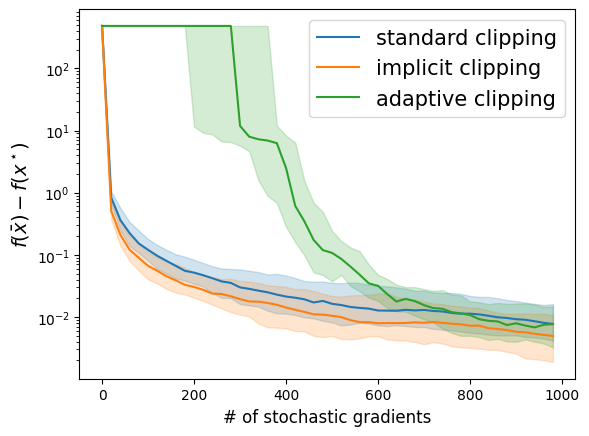

In [20]:
for p in params_list:
    opt_results = optimize_multi(x_0, func, p, T, every)
    mean, top, bottom = opt_results[2]
    plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color)

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 14, 15, 'figure1.pdf')
plt.show()

### clipping vs no clipping

In [21]:
params_list_clipped = [
    StandardClippingDouble(func.L0, func.L1, sigma, R0, T, delta, "clipped SGD", const=10),
    AdaptiveClipped(func.L0, func.L1, sigma, R0, T, delta, "clipped adaptive SGD", const=10),
]
params_list_unclipped = [
    DefaultNoClipping(func.L0, func.L1, sigma, R0, T, delta, "SGD", const=2),
    Adaptive(func.L0, func.L1, sigma, R0, T, delta, "adaptive SGD", const=1),
]
# for p in params_list_clipped:
#     tune(p, has_threshold=True)
# for p in params_list_unclipped:
#     tune(p, has_threshold=False)

In [22]:
clipped_results = [
    optimize_multi(x_0, func, p, T, every)
    for p in params_list_clipped
]
unclipped_results = [
    optimize_multi(x_0, func, p, T, every)
    for p in params_list_unclipped
]

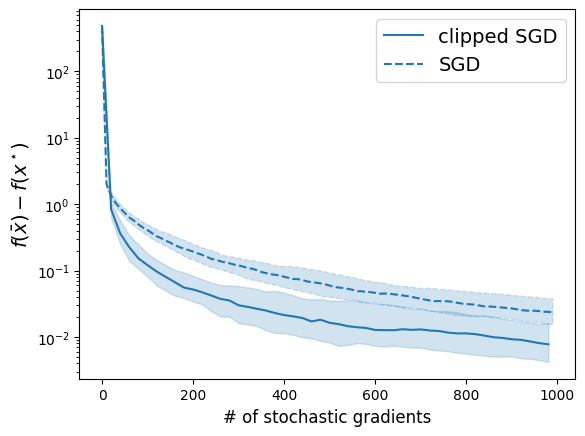

In [23]:
p = params_list_clipped[0]
mean, top, bottom = clipped_results[0][2]
plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color)

p = params_list_unclipped[0]
mean, top, bottom = unclipped_results[0][2]
plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color, linestyle='dashed')

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 14, 14, 'figure5-1.pdf')
plt.show()

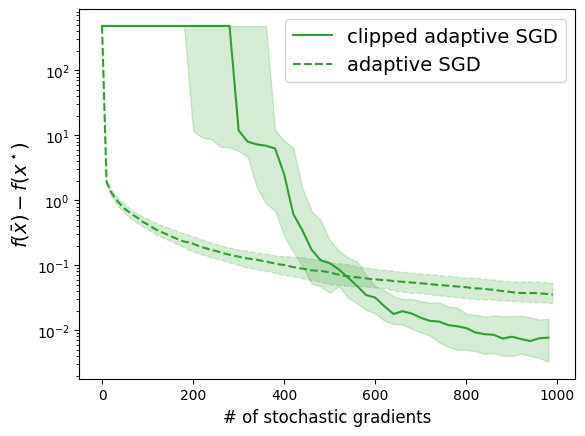

In [24]:
p = params_list_clipped[1]
mean, top, bottom = clipped_results[1][2]
plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color)

p = params_list_unclipped[1]
mean, top, bottom = unclipped_results[1][2]
plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color, linestyle='dashed')

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 14, 14, 'figure5-2.pdf')
plt.show()

In [25]:
# for p in params_list_clipped:
#     opt_results = optimize_multi(x_0, func, p, T, every)
#     mean, top, bottom = opt_results[2]
#     plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color)

# for p in params_list_unclipped:
#     opt_results = optimize_multi(x_0, func, p, T, every)
#     mean, top, bottom = opt_results[1]
#     plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color, linestyle='dashed')

# plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 14, 14, 'figure5.pdf')
# plt.show()

### single sampling vs. double sampling

In [26]:
params_list = [
    StandardClippingDouble(func.L0, func.L1, sigma, R0, T, delta, "double sampling", const=10),
    StandardClippingSingle(func.L0, func.L1, sigma, R0, T, delta, "single sampling", const=10),
]
# for p in params_list:
#     tune(p, has_threshold=True)

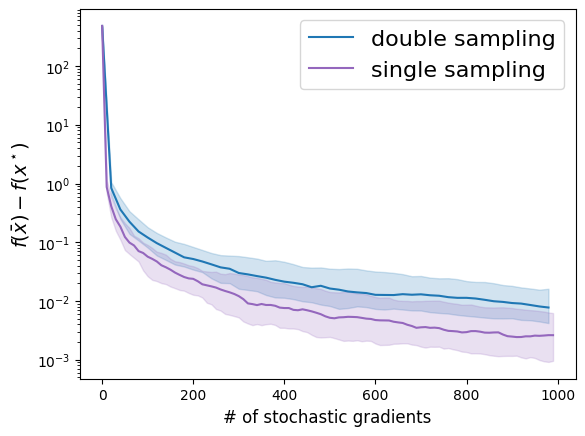

In [27]:
for p in params_list:
    opt_results = optimize_multi(x_0, func, p, T, every)
    mean, top, bottom = opt_results[2]
    plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color)

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 14, 16, 'figure2.pdf')
plt.show()

In [28]:
params_list = [
    StandardClippingDouble(func.L0, func.L1, sigma, R0, T, delta, "double sampling", const=10),
    StandardClippingSingle(func.L0, func.L1, sigma, R0, T, delta, "single sampling", const=10),
]
params_list[0].num_grads_per_step = 1
# tune(params_list[0], has_threshold=True)
# tune(params_list[1], has_threshold=True)

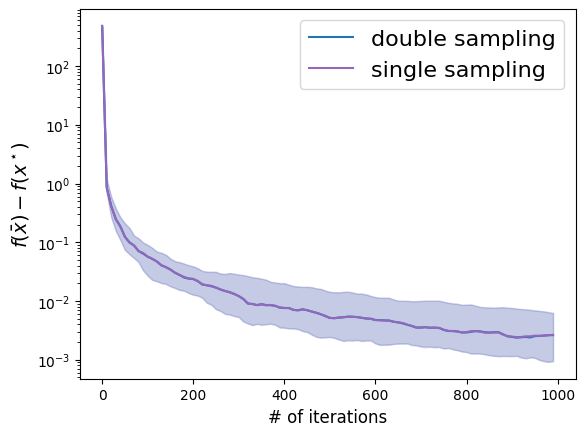

In [29]:
p = params_list[0]
opt_results = optimize_multi(x_0, func, p, T, every)
mean, top, bottom = opt_results[2]
plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color)

p = params_list[1]
opt_results = optimize_multi(x_0, func, p, T, every)
mean, top, bottom = opt_results[2]
plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color)

plot_global_config("# of iterations", 12, r"$f(\bar{x}) - f(x^\star)$", 14, 16, 'figure6.pdf')
plt.show()

### average over $\{1,...,t\}$ vs. average over $\mathcal{T}_2$

In [30]:
params_list = [
    StandardClippingDouble(func.L0, func.L1, sigma, R0, T, delta, "average over all iterates", const=20),
    StandardClippingDouble(func.L0, func.L1, sigma, R0, T, delta, r"average over $\mathcal{T}_2$", const=10)
]
# tune(params_list[0], has_threshold=False)
# tune(params_list[1], has_threshold=True)

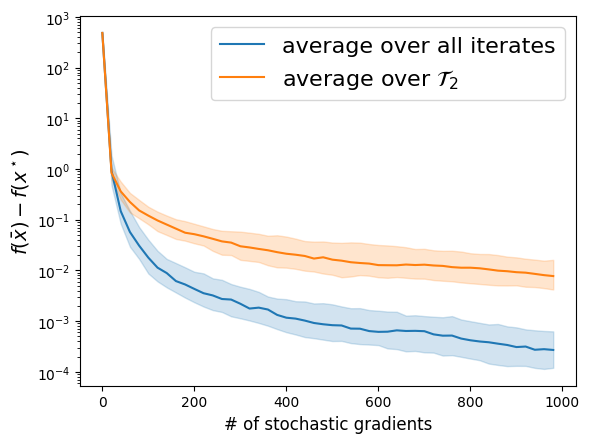

In [31]:
p = params_list[0]
opt_results = optimize_multi(x_0, func, p, T, every)
mean, top, bottom = opt_results[1]
plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color=p.plot_color)

p = params_list[1]
opt_results = optimize_multi(x_0, func, p, T, every)
mean, top, bottom = opt_results[2]
plot_with_shaded_region(range(0,T,every*p.num_grads_per_step), mean, top, bottom, p.name, color='tab:orange')

plot_global_config("# of stochastic gradients", 12, r"$f(\bar{x}) - f(x^\star)$", 14, 16, 'figure3.pdf')
plt.show()

### download the figures generated by the experiments

In [ ]:
import os
from google.colab import files

all_files = os.listdir()
figure_files = [f for f in all_files if f.startswith("figure") and os.path.isfile(f)]

for f in figure_files:
    files.download(f)